# Geolocation Exploratory Analysis of Water Bags in Rio de Janeiro

---
### Notebook Sections:

1. Utility functions
1. Data Cleaning
2. Exploratory Data Analysis
3. Clustering Incidents

### Import modules and functions

In [4]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Define data class to host data paths
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [5]:
catalog = pd.read_csv('Dados/water_bag_catalog_google.csv', parse_dates=True, infer_datetime_format=True)

# Extract records of incidents of water bag formation (copy data for cleaning)
# catalog = catalog[catalog['POP_TITULO']=="Bolsão d'água em via"].copy()
data = catalog.copy()

---
## 0. Utility functions

#### Function to format and correct street number text variable

In [5]:
from Modules.text_formatter import text_transform_pipeline, get_not_number, drop_letters, drop_space, drop_chars, split_avg

#### Plot colored and connected coordinates in 2D plane

In [6]:
from Modules.coord_plot import (
    cmaps, connect_coordinates_colored,
    min_group_size_progression_plot,
    atemporal_evolution_plot
)

---
# 1. Data Cleaning

#### Format and correct street number variable

In [7]:
not_number = get_not_number(catalog['street_number'])
not_number_corrected =  text_transform_pipeline(not_number, [drop_letters, drop_space, drop_chars, split_avg])

data.loc[not_number.index, ['street_number']] = not_number_corrected
data.dropna(subset=['street_number'], inplace=True) # drop rows where street number is missing

#### Data type conversion

In [8]:
float_cols = ['EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'search_lat', 'search_lng', 'street_number']
data[float_cols] = data[float_cols].astype(float)

---
# 2. Exploratory Data Analysis

### 1. Coordinades visualization

#### Scatter plot of original coordinates

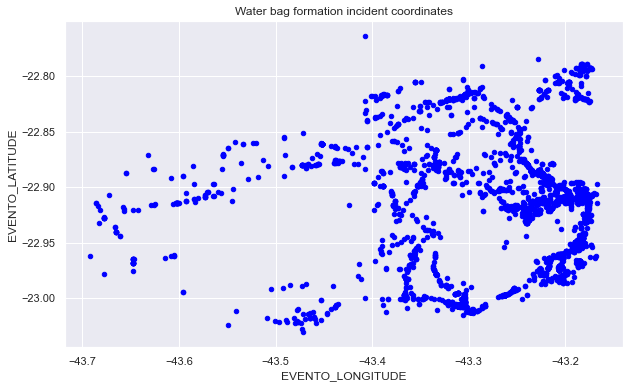

In [9]:
data.plot(
    'EVENTO_LONGITUDE', 'EVENTO_LATITUDE', kind='scatter',
    c='blue', figsize=(10, 6),
    title='Water bag formation incident coordinates'
); plt.show()

### 2. Incidents per rout

#### Incidents per route - top 15

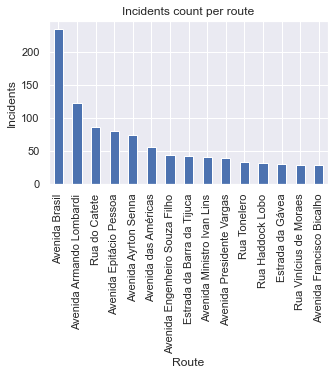

In [10]:
route_count = data['route'].value_counts().rename('Incident Count')
fig, ax = plt.subplots(figsize=(5, 3))
route_count.head(15).plot.bar(
    title='Incidents count per route',
)
ax.set(
    ylabel='Incidents',
    xlabel='Route'
)
plt.show()

#### Excluding routes with less than dinamic 'min_incidents' - Animation

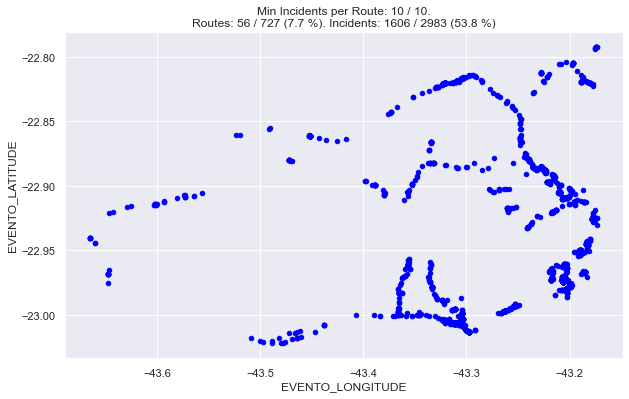

In [27]:
recurrence = min_group_size_progression_plot(
    data, ['EVENTO_LONGITUDE', 'EVENTO_LATITUDE'], 'route',
    max_incidents=10, pause=0.5,
    figsize=(10, 6), color='blue'
)

#### Percentage of routes and incidents left in routes where min incidents is 8

In [12]:
min_incidents = 4; recurrence[recurrence['min_incidents']>=min_incidents]

,min_incidents,n_routes,n_incidents,p_routes (%),p_incidents (%)
4,4,158,2172,21.7,72.8
5,5,119,2016,16.4,67.6
6,6,96,1901,13.2,63.7
7,7,87,1847,12.0,61.9
8,8,74,1756,10.2,58.9
9,9,62,1660,8.5,55.6
10,10,56,1606,7.7,53.8


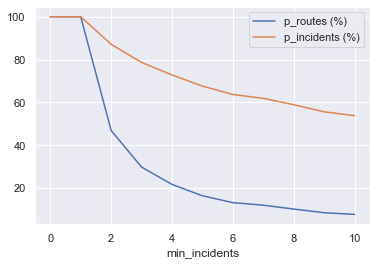

In [14]:
ax = recurrence.set_index('min_incidents')[['p_routes (%)', 'p_incidents (%)']].plot()

#### Extracting incidents of top 50 routes

In [15]:
rec_routes = route_count[route_count >= min_incidents]
rec_data = data[data['route'].isin(rec_routes.index)]
rec_routes.tail()

Rua Barata Ribeiro           4
Avenida Rio Branco           4
Avenida Marechal Floriano    4
Rua do Passeio               4
Rua Erico Coelho             4
Name: Incident Count, dtype: int64

### 3. Routes Visualization 

#### Line & Scatter plot of coordinates (colored by route and connected by address street number order)

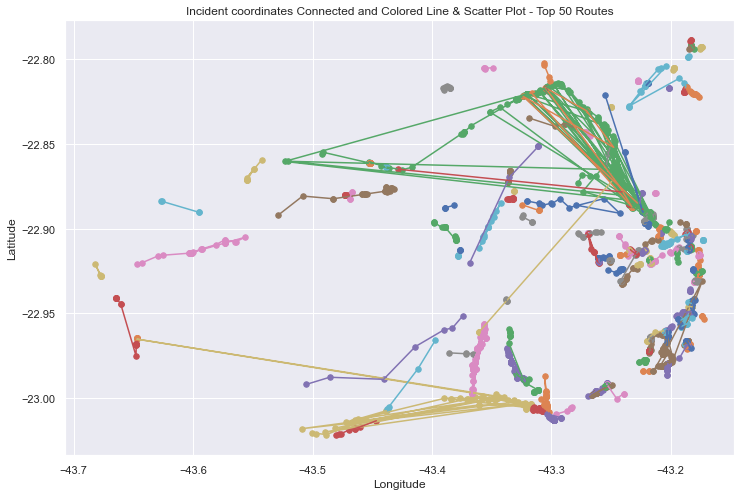

In [17]:
connect_coordinates_colored(
    rec_data['search_lng'], rec_data['search_lat'],
    rec_data['route'], rec_data['street_number'], cmap=None,
    title='Incident coordinates Connected and Colored Line & Scatter Plot - Top 50 Routes',
    figsize=(12, 8), connect=True, scatter=True
)

Obs: Street number order for records in the same route is not matching for some specific big routes.

### 4. Route and street number statistical analysis 

#### Street numbers statistical description per route (top 10)

In [18]:
number_desc = data.groupby('route')['street_number'].describe().sort_values('count', ascending=False)
number_desc.head(10)

,count,mean,std,min,25%,50%,75%,max
route,,,,,,,,
Avenida Brasil,235.0,4914.454745,8170.248330,13.0,211.0,500.0,5420.00,35025.0
Avenida Armando Lombardi,123.0,339.861789,430.901577,33.0,188.0,188.0,350.00,3652.0
Rua do Catete,87.0,175.724138,55.524285,1.0,139.0,195.0,228.00,228.0
Avenida Epitácio Pessoa,81.0,1629.308642,1413.060178,5.0,165.0,1612.0,2690.00,4800.0
Avenida Ayrton Senna,74.0,2434.189189,2388.383282,80.0,300.0,2400.0,4581.75,9001.0
Avenida das Américas,57.0,5079.501754,6514.539946,12.3,801.0,2250.0,4444.00,20035.0
Avenida Engenheiro Souza Filho,44.0,1374.454545,801.623018,10.0,586.5,1190.0,2100.00,2631.0
Estrada da Barra da Tijuca,43.0,1426.906977,634.024103,186.0,1030.0,1636.0,1716.00,3163.0
Avenida Ministro Ivan Lins,41.0,749.097561,354.292662,11.0,740.0,850.0,850.00,1770.0


#### Routes' street number range statistical description

In [19]:
number_range = ( number_desc['max'] - number_desc['min'] ).rename('Street Number Range')
number_range.describe()

count      727.000000
mean       614.483398
std       2645.060878
min          0.000000
25%          0.000000
50%          0.000000
75%        139.000000
max      35012.000000
Name: Street Number Range, dtype: float64

Obs: Street number range has good potential to segment routes

#### Routes' street number range percentiles

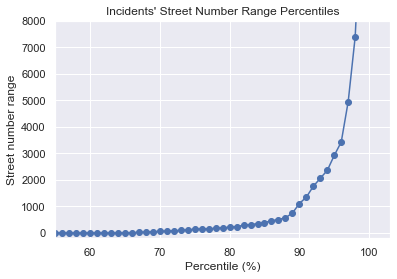

In [20]:
prcts = range(0, 101, 1)
percentiles = pd.Series(np.percentile(number_range, prcts), index=prcts)
plt.plot(percentiles, marker='o')
plt.title("Incidents' Street Number Range Percentiles")
plt.xlabel('Percentile (%)')
plt.ylabel("Street number range")
plt.xlim((55, 103))
plt.ylim((-200, 8000))
plt.show()

Obs: Street number ranges are distributed uniformly along three natural intervals. This means there are three major scales to classify streets by street number ranges of formation of water bags.


In [21]:
bins = [600, 4000]

#### Linear incident density per route - incidents per 10 m (Top 10 excluding routes with number range less than 10 meters)

In [22]:
route_numbers_density = ( route_count / number_range * 10 ).sort_values(ascending=False).rename('Incidents per 10 m')
density = pd.concat([route_numbers_density, route_count, number_range], 1); density[number_range>=7].head(10)

<ipython-input-22-fef8f96ee413>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  density = pd.concat([route_numbers_density, route_count, number_range], 1); density[number_range>=7].head(10)


,Incidents per 10 m,Incident Count,Street Number Range
Avenida Heitor Beltrão,8.000000,8,10.0
Rua do Rezende,4.666667,7,15.0
Rua José do Patrocínio,4.285714,3,7.0
Rua do Catete,3.832599,87,227.0
Rua do Passeio,3.076923,4,13.0
Avenida Professor Pereira Reis,3.000000,3,10.0
Rua da Lapa,3.000000,3,10.0
Estrada da Cancela Preta,2.857143,24,84.0
Rua Gago Coutinho,2.777778,5,18.0
Rua Leonor Pôrto,2.500000,3,12.0


c:\Users\luisr\anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


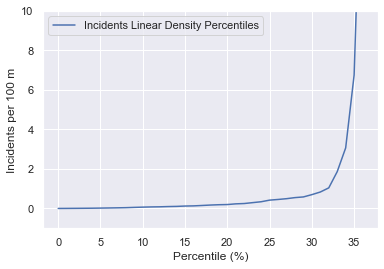

In [23]:
ax = pd.Series(np.percentile(density.iloc[:, 0], range(101)), name='Incidents Linear Density Percentiles').to_frame().plot(
    ylim=(-1, 10)
)
ax.set(ylabel='Incidents per 100 m', xlabel='Percentile (%)'), 
plt.show()

Obs: The linear density division here is below and above 10 incidents per 100 meters. Routes with more than 10 incidents per 100 meter have incidents concentrated in very small regions.

### 5. Incidents time evolution

In [24]:
file_path = 'Plots/Animations/Water Bag Formation Time Evolution JPG'
filename = '/frame_{}.jpg'

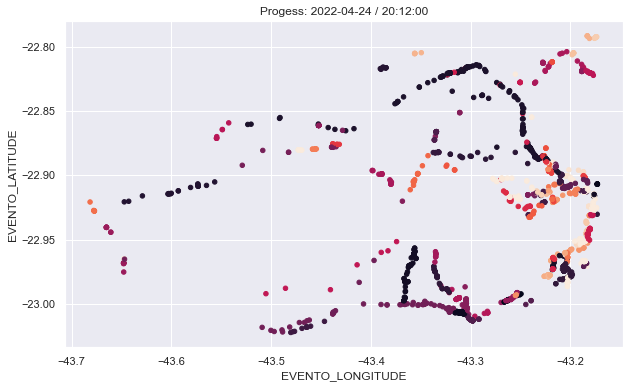

In [31]:
atemporal_evolution_plot(
    data, coord_cols=['EVENTO_LONGITUDE', 'EVENTO_LATITUDE'],
    time_col='EVENTO_INICIO', color='blue',
    group_col='route', min_per_group=5,
    cmap=None, lut=100,
    pause=.1, frame_evolution=25, freq='W',
    figsize=(10,6),
#     path=file_path+filename
)

#### Save animation ass giff

In [25]:
from Modules.gif_builder import folder_to_gif_stream

In [26]:
gif_path = 'Plots/Animations/Water Bag Time Evolution.gif'

#  folder_to_gif_stream(file_path, gif_path, duration=0.3)